In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
from os import path
from PIL import Image
from string import punctuation
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
train = pd.read_csv('../data/raw/drugs_train.tsv', sep='\t')
test = pd.read_csv('../data/raw/drugs_test.tsv', sep='\t')

In [3]:
stopwords = set(stopwords.words('english'))

In [4]:
train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
print("Missing data in TRAIN file: \n{}".format(train.isnull().sum()))

Missing data in TRAIN file: 
Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64


In [6]:
print("Missing data in TEST file: \n{}".format(test.isnull().sum()))

Missing data in TEST file: 
Unnamed: 0       0
drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64


In [7]:
print("Number of unique drugs: {}".format(train.drugName.unique().shape[0]))
print("Number of unique conditions: {}".format(train.condition.unique().shape[0]))

Number of unique drugs: 3436
Number of unique conditions: 885


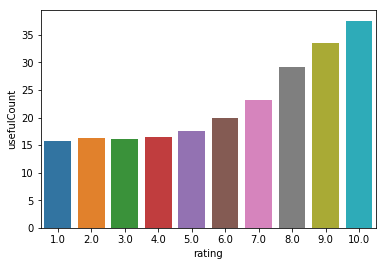

In [8]:
sns.barplot(x='rating', y='usefulCount', data=train, ci=None)

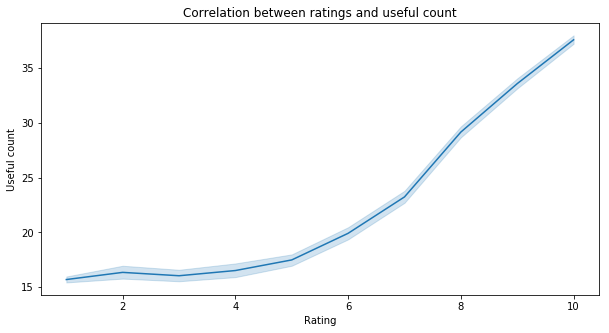

In [9]:
plt.figure(figsize=(10,5))
sns.lineplot(x='rating', y='usefulCount', data=train)

plt.xlabel("Rating")
plt.ylabel("Useful count")
plt.title("Correlation between ratings and useful count")
plt.show()

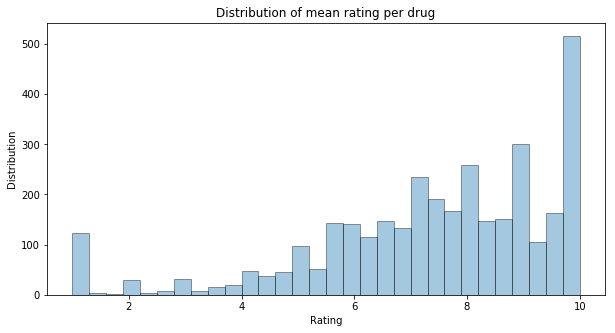

In [10]:
plt.figure(figsize=(10,5))
sns.distplot(train['rating'].groupby(train['drugName']).mean(), hist=True, kde=False, hist_kws={'edgecolor':'black'}, bins=30)

plt.xlabel('Rating')
plt.ylabel('Distribution')
plt.title("Distribution of mean rating per drug")
plt.show()

In [11]:
sent_analyzer = SentimentIntensityAnalyzer()

sentiments = []

for review in train.review:
    sentiments.append(sent_analyzer.polarity_scores(review).get('compound'))

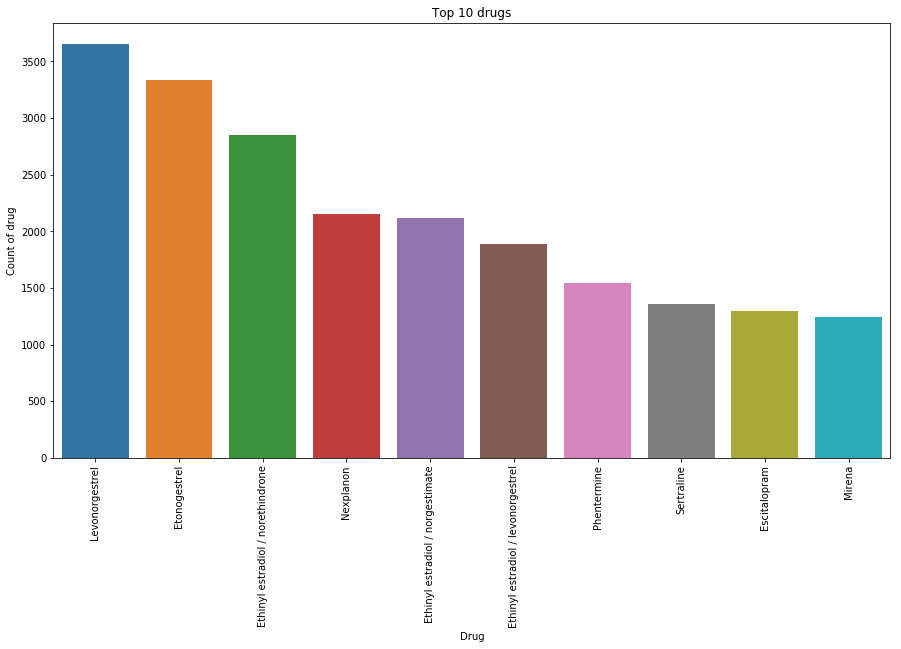

In [12]:
drugs = train['drugName'].value_counts()
plt.figure(figsize=(15,8))

sns.barplot(drugs[:10].index, drugs[:10])

plt.xlabel("Drug")
plt.xticks(rotation='vertical')
plt.ylabel("Count of drug")
plt.title("Top 10 drugs")
plt.show()

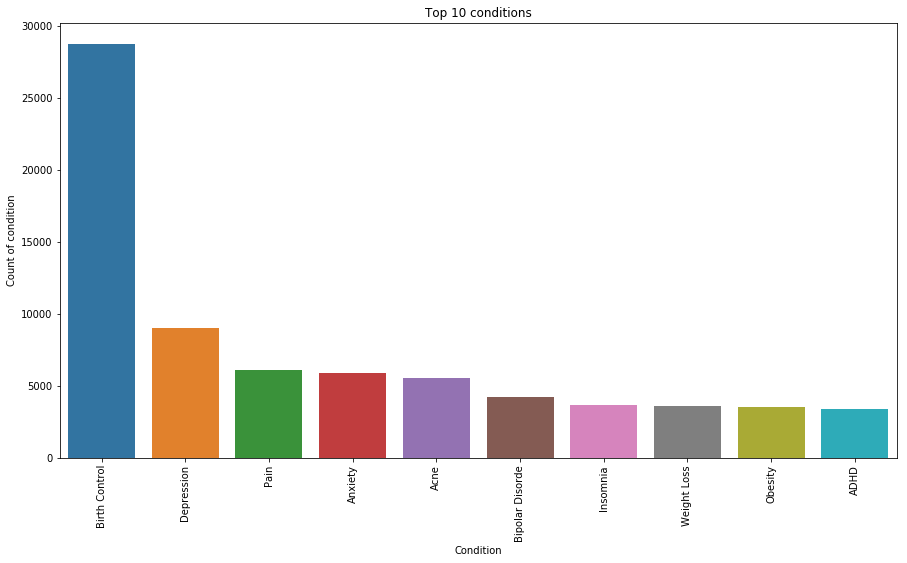

In [13]:
conditions = train['condition'].value_counts()
plt.figure(figsize=(15,8))

sns.barplot(conditions[:10].index, conditions[:10])

plt.xlabel("Condition")
plt.xticks(rotation='vertical')
plt.ylabel("Count of condition")
plt.title("Top 10 conditions")
plt.show()

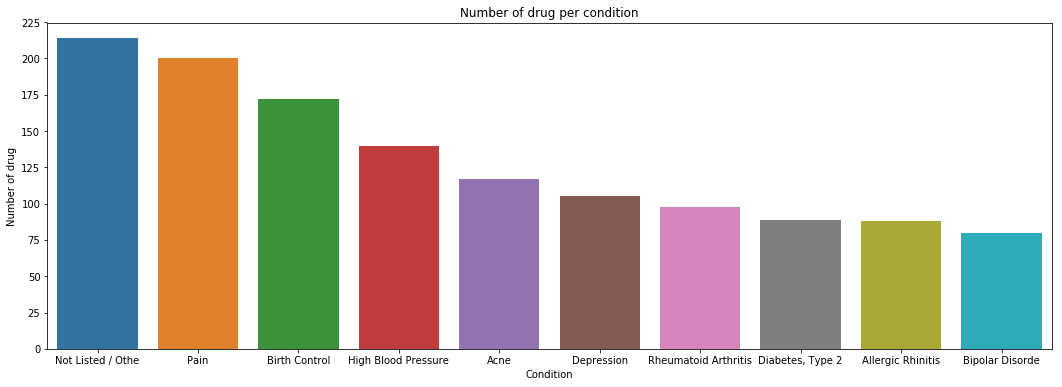

In [14]:
drugs_per_condition = train['drugName'].groupby(train['condition']).nunique().sort_values(ascending=False)
plt.figure(figsize=(18,6))
sns.barplot(drugs_per_condition[:10].index, drugs_per_condition[:10])

plt.xlabel("Condition")
plt.ylabel("Number of drug")
plt.title("Number of drug per condition")
plt.show()

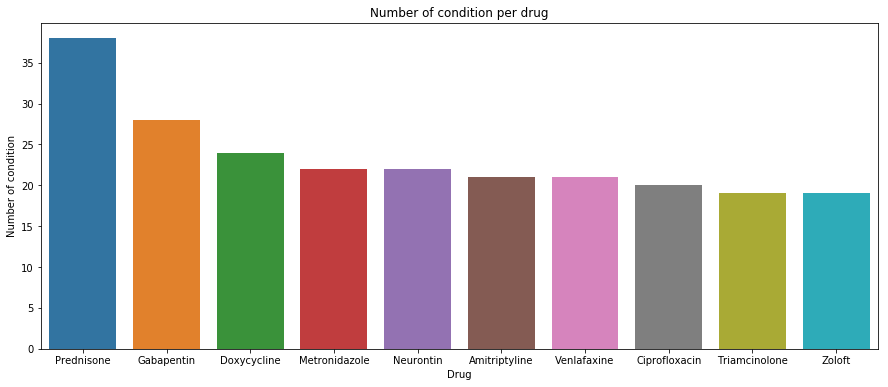

In [15]:
condition_per_drugs = train['condition'].groupby(train['drugName']).nunique().sort_values(ascending=False)
plt.figure(figsize=(15,6))
sns.barplot(condition_per_drugs[:10].index, condition_per_drugs[:10])

plt.xlabel("Drug")
plt.ylabel("Number of condition")
plt.title("Number of condition per drug")
plt.show()

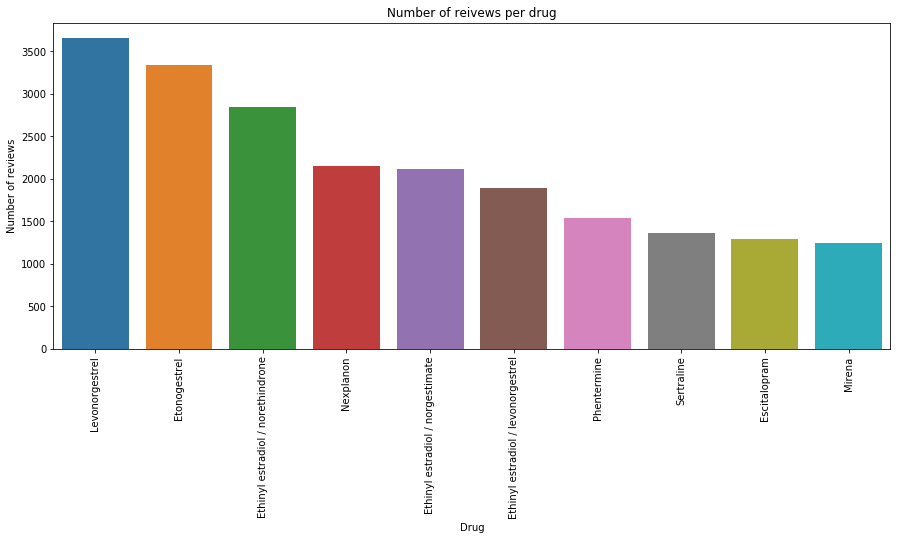

In [16]:
reviews_per_drugs = train['review'].groupby(train['drugName']).nunique().sort_values(ascending=False)
plt.figure(figsize=(15,6))
sns.barplot(reviews_per_drugs[:10].index, reviews_per_drugs[:10])

plt.xlabel("Drug")
plt.xticks(rotation='vertical')
plt.ylabel("Number of reviews")
plt.title("Number of reivews per drug")
plt.show()

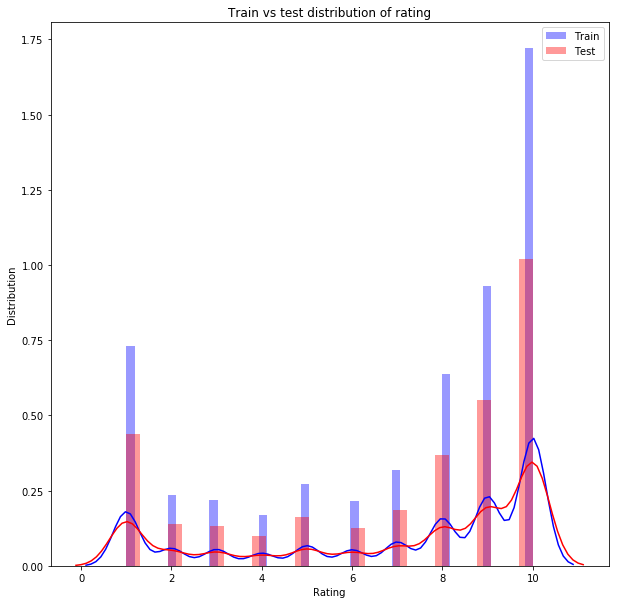

In [17]:
plt.figure(figsize=(10,10))
sns.distplot(train.rating, label='Train', color='blue')
sns.distplot(test.rating, label='Test', color='red')

plt.xlabel("Rating")
plt.ylabel("Distribution")
plt.title("Train vs test distribution of rating")
plt.legend()
plt.show()

In [18]:
new_data_frame = train.copy()

In [19]:
new_data_frame['sentiment'] = pd.Series(data=np.asarray(sentiments))

In [20]:
new_data_frame[['rating', 'sentiment']].head(10)

,rating,sentiment
0,9.0,-0.2960
1,8.0,0.8603
2,5.0,0.7645
3,8.0,0.7184
4,9.0,0.9403
5,2.0,-0.4342
6,1.0,0.0000
7,10.0,-0.9468
8,1.0,-0.5593
9,8.0,-0.9010


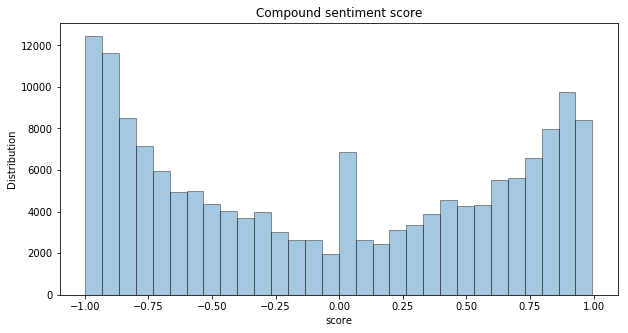

In [21]:
plt.figure(figsize=(10,5))
sns.distplot(new_data_frame['sentiment'], hist=True, kde=False, hist_kws={'edgecolor':'black'}, bins=30)

plt.xlabel("score")
plt.ylabel("Distribution")
plt.title("Compound sentiment score")
plt.show()

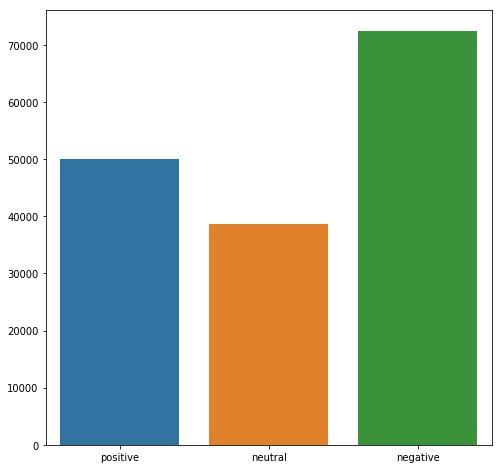

In [22]:
plt.figure(figsize=(8, 8))
pos_sent = new_data_frame[new_data_frame['sentiment'] >= 0.5]
neutral_sent = new_data_frame[(new_data_frame['sentiment'] > -0.25) & (new_data_frame['sentiment'] < 0.5)]
neg_sent = new_data_frame[new_data_frame['sentiment'] <= -0.25]
sns.barplot(["positive", "neutral", "negative"], [len(pos_sent), len(neutral_sent), len(neg_sent)])

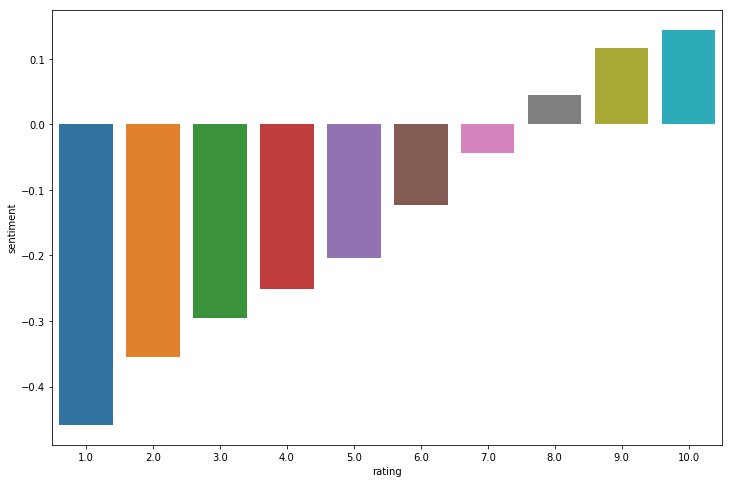

In [23]:
plt.figure(figsize=(12, 8))
sns.barplot(new_data_frame.rating, new_data_frame.sentiment, ci=None)

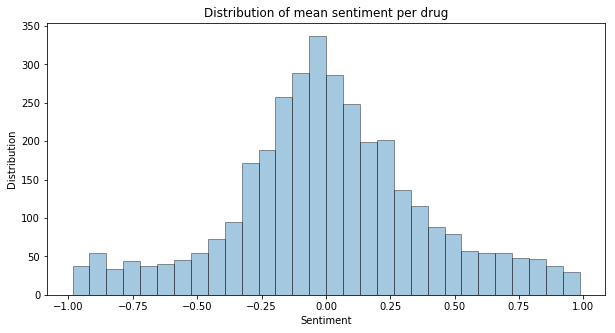

In [24]:
plt.figure(figsize=(10,5))
sns.distplot(new_data_frame['sentiment'].groupby(new_data_frame['drugName']).mean(), hist=True, kde=False, hist_kws={'edgecolor':'black'}, bins=30)

plt.xlabel('Sentiment')
plt.ylabel('Distribution')
plt.title("Distribution of mean sentiment per drug")
plt.show()

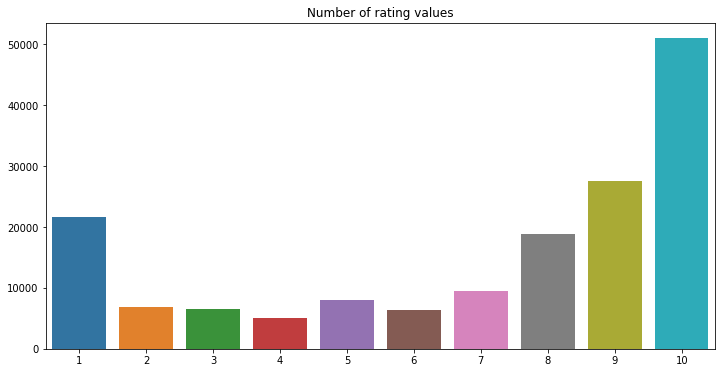

In [25]:
plt.figure(figsize=(12, 6))
ratings = new_data_frame.rating.value_counts().sort_values(ascending=False)
sns.barplot(ratings.index.astype(int), ratings)

plt.xlabel("")
plt.ylabel("")
plt.title("Number of rating values")
plt.show()

Assume that positive sentiment is greater than 7, negative sentiment is less than 5 and neutral sentiment is the rest.

In [26]:
def convert_ratings(data):
    ratings = []
    for rate in data:
        if rate <= 4:
            ratings.append(0)
        elif rate > 4 and rate < 9 :
            ratings.append(1)
        else:
            ratings.append(2)

    return ratings

In [27]:
new_data_frame['rating'] = convert_ratings(new_data_frame['rating'])

In [28]:
positive = new_data_frame[new_data_frame.iloc[:, 4] == 2]
negative = new_data_frame[new_data_frame.iloc[:, 4] == 1]
neutral = new_data_frame[new_data_frame.iloc[:, 4] == 0]

In [29]:
print("Number of POSITIVE ratings: {}".format(len(positive)))
print("Number of NEGATIVE ratings: {}".format(len(negative)))
print("Number of NEUTRAL ratings: {}".format(len(neutral)))

Number of POSITIVE ratings: 78520
Number of NEGATIVE ratings: 42702
Number of NEUTRAL ratings: 40075


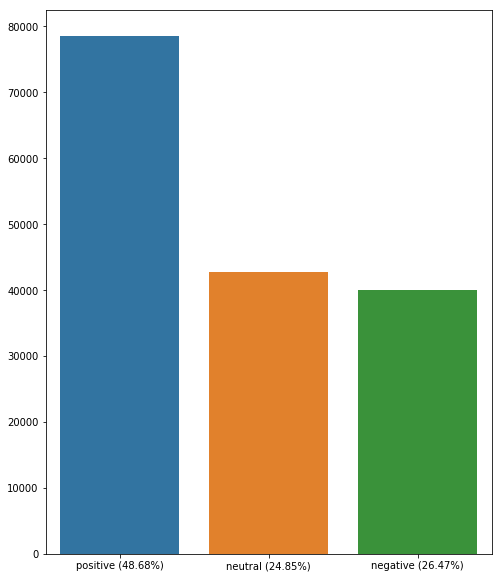

In [30]:
pos_procent = (len(positive)/len(train.rating)) * 100
neg_procent = (len(negative)/len(train.rating)) * 100
neut_procent = (len(neutral)/len(train.rating)) * 100

plt.figure(figsize=(8,10))
sns.barplot(['positive ({:.2f}%)'.format(pos_procent), 'neutral ({:.2f}%)'.format(neut_procent),'negative ({:.2f}%)'.format(neg_procent)], [len(positive), len(negative), len(neutral)])

In [31]:
text = " ".join(review for review in train.review)
print("Number of reviews: {}".format(len(text)))

Number of reviews: 74152462


In [32]:
stop_words = [x for x in open('../data/raw/clinical_stopwords.txt','r').read().split('\n')]
stopwords.update(stop_words)

In [33]:
def word_cloud(data):
    wordcloud = WordCloud(stopwords=stopwords, max_words=100, background_color="white").generate(data)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

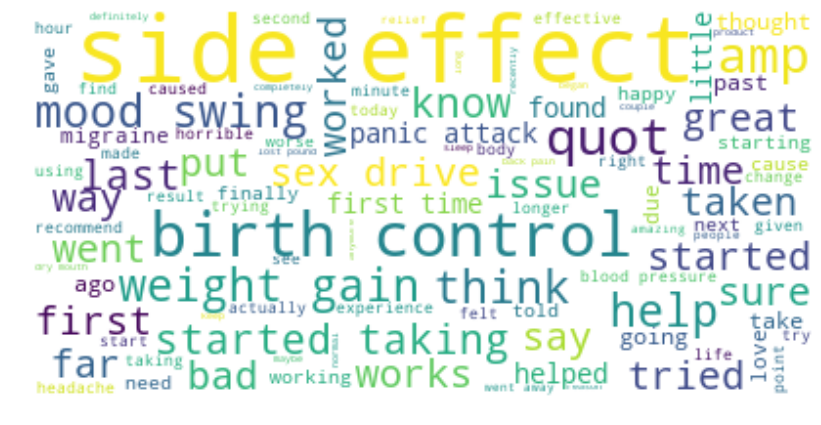

In [34]:
word_cloud(text)

In [35]:
def top_freq_words(data):
    frequency = {}
    pattern = re.findall(r'\b[a-z]{4,20}\b', data)

    for word in pattern:
        count = frequency.get(word, 0)
        frequency[word] = count + 1

    sorted_num_words = sorted(frequency.items(), key=lambda x: x[1], reverse=True)
    words_dict = dict((x, y) for x, y in sorted_num_words)

    wordcloud = WordCloud(stopwords=stopwords, max_words=20, background_color="white")
    wordcloud.fit_words(words_dict)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

Top frequent positive, neutral and negative words.

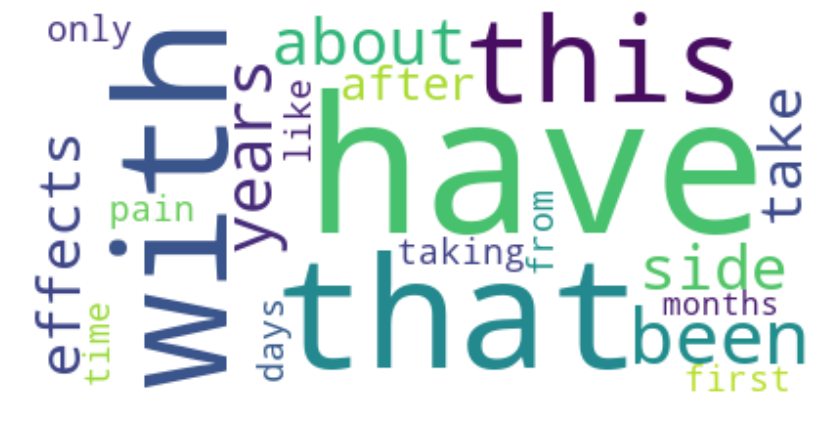

In [36]:
top_freq_words(''.join(positive.review.values))

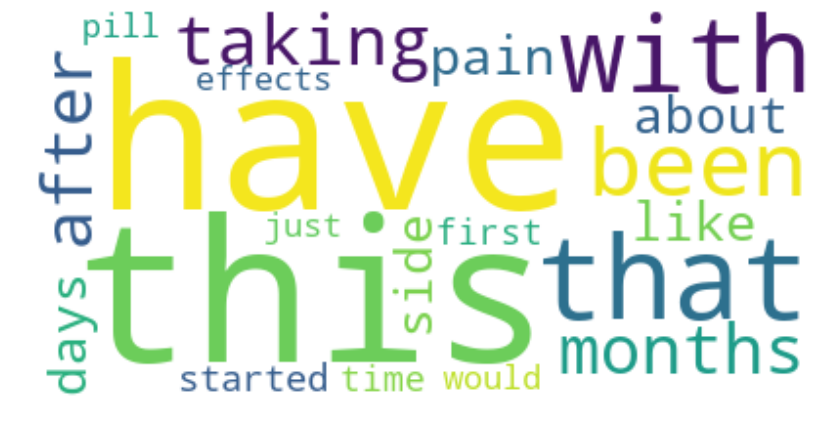

In [37]:
top_freq_words(''.join(neutral.review.values))

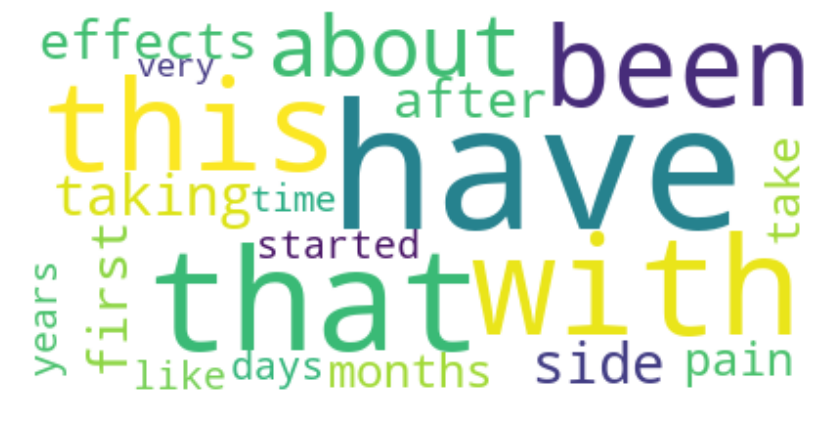

In [38]:
top_freq_words(''.join(negative.review.values))

In [39]:
num_of_words = [len(review.split()) for review in train.review]

Descriptive statistics of words from review.

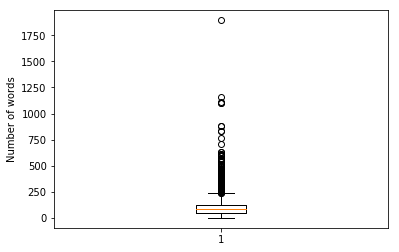

In [40]:
plt.boxplot(num_of_words)

plt.xlabel("")
plt.ylabel("Number of words")
plt.show()

In [41]:
pd.options.display.float_format = '{:.2f}'.format
words_df = pd.DataFrame({"words" : num_of_words})
words_df.describe()

,words
count,161297.00
mean,84.70
std,45.04
min,1.00
25%,48.00
50%,84.00
75%,126.00
max,1894.00
